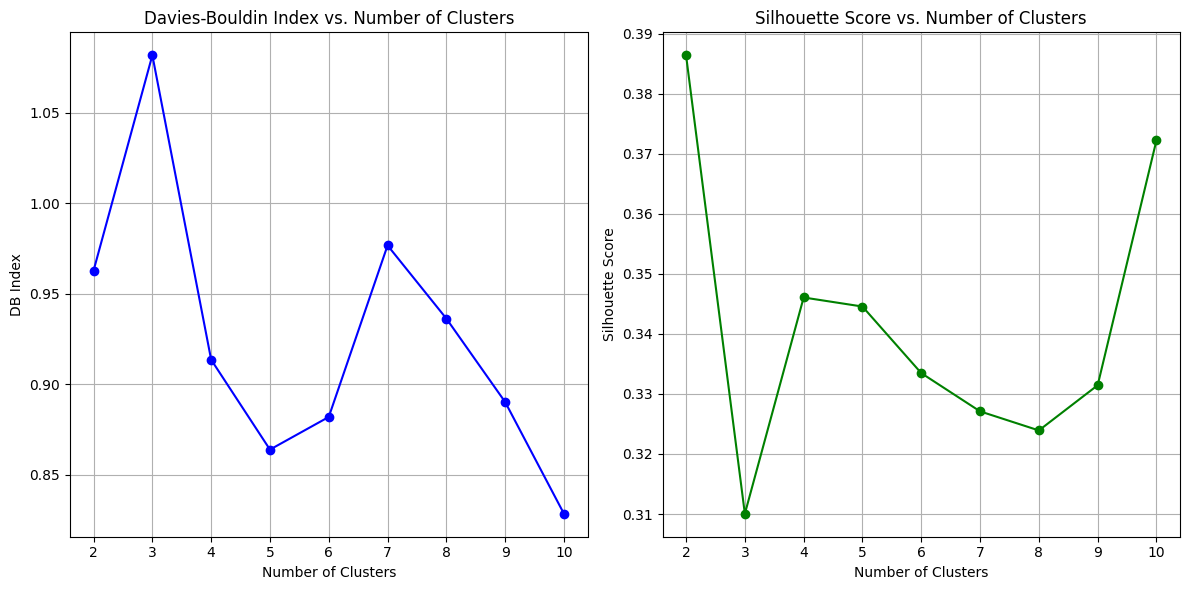

Optimal Number of Clusters: 4
Final Davies-Bouldin Index: 0.9136644620804093
Final Silhouette Score: 0.3460691785805992


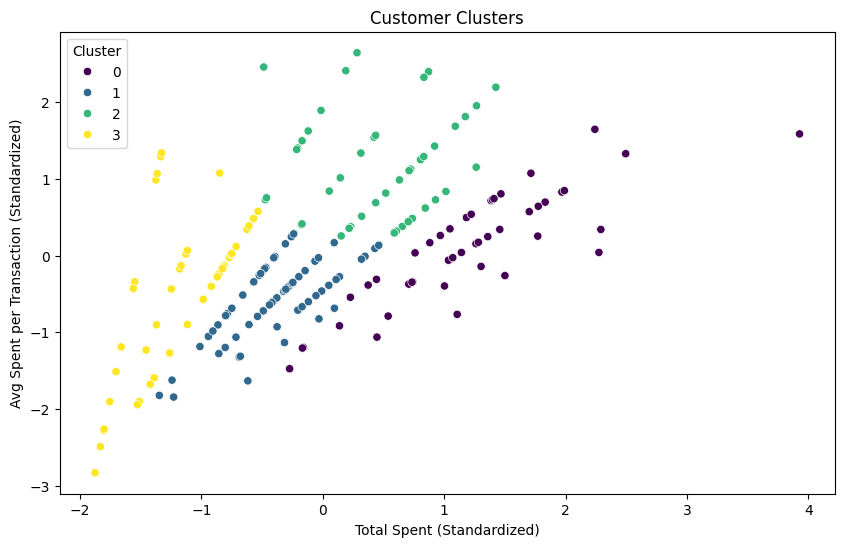

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Feature engineering from Transactions.csv
transaction_features = transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count"),
    avg_spent_per_transaction=("TotalValue", "mean"),
    unique_products=("ProductID", "nunique")
).reset_index()

# Merge with Customers.csv
data = customers.merge(transaction_features, on="CustomerID", how="left")
data.fillna(0, inplace=True)

# Encode categorical variables (e.g., Region)
data = pd.get_dummies(data, columns=["Region"], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ["total_spent", "total_transactions", "avg_spent_per_transaction", "unique_products"]
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Determine the optimal number of clusters using Davies-Bouldin Index and Silhouette Score
db_scores = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data[numerical_features])
    
    db_index = davies_bouldin_score(data[numerical_features], labels)
    db_scores.append(db_index)
    
    silhouette_avg = silhouette_score(data[numerical_features], labels)
    silhouette_scores.append(silhouette_avg)

# Plot Davies-Bouldin Index and Silhouette Score
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, db_scores, marker='o', label="DB Index", color='blue')
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', label="Silhouette Score", color='green')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# Select the optimal number of clusters (e.g., based on DB Index or Silhouette Score)
optimal_k = 4  # Replace with chosen value based on above plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data["Cluster"] = kmeans.fit_predict(data[numerical_features])

# Compute final metrics for chosen k
final_db_index = davies_bouldin_score(data[numerical_features], data["Cluster"])
final_silhouette_score = silhouette_score(data[numerical_features], data["Cluster"])

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Final Davies-Bouldin Index: {final_db_index}")
print(f"Final Silhouette Score: {final_silhouette_score}")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data["total_spent"], 
    y=data["avg_spent_per_transaction"], 
    hue=data["Cluster"], 
    palette="viridis"
)
plt.title("Customer Clusters")
plt.xlabel("Total Spent (Standardized)")
plt.ylabel("Avg Spent per Transaction (Standardized)")
plt.legend(title="Cluster")
plt.show()

# Save clustering results
data[["CustomerID", "Cluster"]].to_csv("Clustering_Results.csv", index=False)
